In [1]:
import pandas as pd
import numpy as np

In [1]:
import pymc3 as pm

In [5]:
data = pd.read_csv("../ab_data.csv")

# Filter rows with non-negative values in specified columns
data = data[(data['days_since_account_creation'] >= 0) &
            (data['num_downloads'] >= 0) &
            (data['num_searches'] >= 0)]

data['date'] = pd.to_datetime(data['date'])

# Convert subscription and group columns to binary values
data['subscription'] = np.where(data['subscription'] == "paid", 1, 0)
data['group'] = np.where(data['group'] == "popup_1", 1, 2)

# Filter rows with missing values in group, click_yes, or click_no columns
na_values = data[data['group'].isna() |
                 data['click_yes'].isna() |
                 data['click_no'].isna()]

# Clean data by removing rows with missing or empty group values
clean_data_group = data.dropna(subset=['group']).astype({'group': int})

data.head()


,user_id,group,country,career,subscription,date,hour,click_yes,click_no,days_since_account_creation,num_downloads,num_searches
0,1,1,England,KS1,1,2020-07-10,8,0,0,1166,1,32.0
1,2,1,England,KS1,1,2020-07-07,10,0,0,5,227,21.0
2,3,1,Scotland,NaN,1,2020-07-05,2,0,1,80,0,0.0
3,4,2,NaN,NaN,1,2020-07-03,15,0,0,1176,0,0.0
4,5,2,England,KS1,1,2020-07-03,15,0,0,743,126,40.0


In [9]:

# Filter overall data for rows with click_yes or click_no
overall = data[(data['click_no'] == 1) | (data['click_yes'] == 1)][['user_id', 'group', 'click_yes', 'click_no', 'date']]

# Filter overall data for the first four days
first_four_days = overall[(overall['date'] >= overall['date'].min()) &
                          (overall['date'] <= overall['date'].min() + pd.Timedelta(days=3))][['group', 'click_yes', 'date']]

# Filter overall data for the last four days
last_four_days = overall[(overall['date'] >= overall['date'].max() - pd.Timedelta(days=3)) &
                         (overall['date'] <= overall['date'].max())][['group', 'click_yes', 'date']]

In [10]:
last_four_days

,group,click_yes,date
23,2,1,2020-07-08
39,1,0,2020-07-10
65,1,1,2020-07-09
80,1,0,2020-07-09
95,1,0,2020-07-08
...,...,...,...
8031,2,1,2020-07-10
8042,1,1,2020-07-09
8058,1,0,2020-07-09
8064,2,0,2020-07-09


In [25]:
# Prior dataset for Group A
prior_sample_size_b = 289
prior_conversions_b = 140

# Posterior dataset for Group A
posterior_sample_size_b = 340
posterior_conversions_b = 156

# Prior dataset for Group B
prior_sample_size_a = 354
prior_conversions_a = 155

# Posterior dataset for Group B
posterior_sample_size_a = 201
posterior_conversions_a = 95


In [11]:

# Define the model
with pm.Model() as ab_model:
    # Prior distributions for conversion rates
    theta_prior_a = pm.Beta('theta_prior_a', prior_conversions_a + 1, prior_sample_size_a - prior_conversions_a + 1)
    theta_prior_b = pm.Beta('theta_prior_b', prior_conversions_b + 1, prior_sample_size_b - prior_conversions_b + 1)

    # Likelihoods for posterior data
    y_posterior_a = pm.Binomial('y_posterior_a', n=posterior_sample_size_a, p=theta_prior_a, observed=posterior_conversions_a)
    y_posterior_b = pm.Binomial('y_posterior_b', n=posterior_sample_size_b, p=theta_prior_b, observed=posterior_conversions_b)

    # Generate posterior samples
    trace = pm.sample(draws=5000, tune=2000, chains=4)

    # Print summary statistics
    print(pm.summary(trace))

    # Plot posterior distributions
    #pm.plot_posterior(trace, var_names=['theta_prior_a', 'theta_prior_b'], ref_val=0.5)

    # Calculate the probability of Group B being better than Group A
    #p_b_better = (trace['theta_prior_b'] > trace['theta_prior_a']).mean()
    #print(f'Probability that Group B is better than Group A: {p_b_better:.2%}')


/Users/cex/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_prior_b, theta_prior_a]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 24 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_prior_a  0.471  0.020   0.434    0.508        0.0      0.0   17515.0   
theta_prior_b  0.451  0.021   0.412    0.491        0.0      0.0   17180.0   

               ess_tail  r_hat  
theta_prior_a   13821.0    1.0  
theta_prior_b   14963.0    1.0  


In [26]:
# country
# Prior dataset for Group A
prior_sample_size_b = 170
prior_conversions_b = 76

# Posterior dataset for Group A
posterior_sample_size_b = 199
posterior_conversions_b = 94

# Prior dataset for Group B
prior_sample_size_a = 201
prior_conversions_a = 89

# Posterior dataset for Group B
posterior_sample_size_a = 123
posterior_conversions_a = 55


/Users/cex/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_prior_b, theta_prior_a]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 20 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_prior_a  0.445  0.028   0.393    0.496        0.0      0.0   17040.0   
theta_prior_b  0.461  0.026   0.413    0.509        0.0      0.0   17410.0   

               ess_tail  r_hat  
theta_prior_a   14142.0    1.0  
theta_prior_b   14965.0    1.0  
Probability that Group B is better than Group A: 66.26%


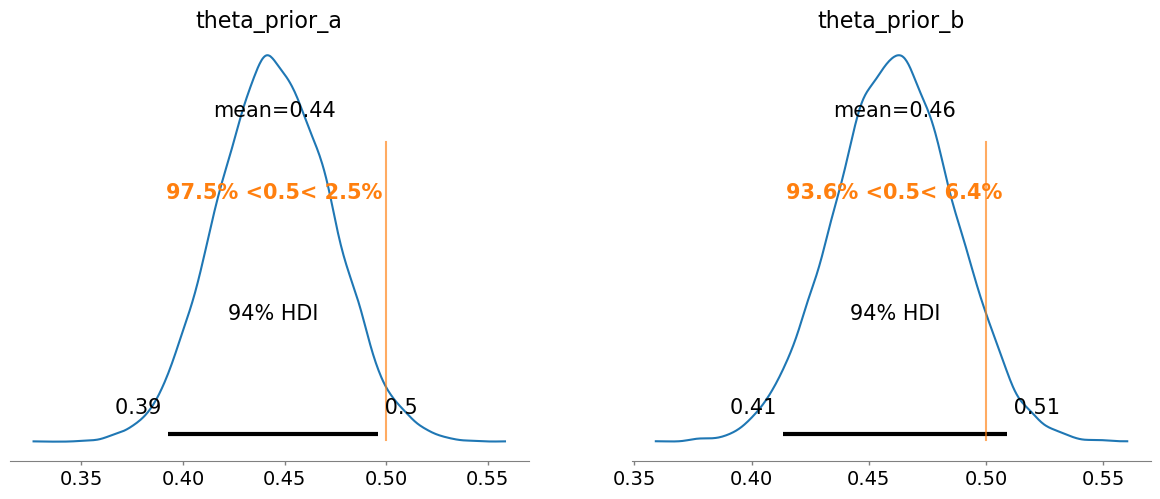

In [27]:
# Define the model
with pm.Model() as ab_model:
    # Prior distributions for conversion rates
    theta_prior_a = pm.Beta('theta_prior_a', prior_conversions_a + 1, prior_sample_size_a - prior_conversions_a + 1)
    theta_prior_b = pm.Beta('theta_prior_b', prior_conversions_b + 1, prior_sample_size_b - prior_conversions_b + 1)

    # Likelihoods for posterior data
    y_posterior_a = pm.Binomial('y_posterior_a', n=posterior_sample_size_a, p=theta_prior_a, observed=posterior_conversions_a)
    y_posterior_b = pm.Binomial('y_posterior_b', n=posterior_sample_size_b, p=theta_prior_b, observed=posterior_conversions_b)

    # Generate posterior samples
    trace = pm.sample(draws=5000, tune=2000, chains=4)

    # Print summary statistics
    print(pm.summary(trace))

    # Plot posterior distributions
    pm.plot_posterior(trace, var_names=['theta_prior_a', 'theta_prior_b'], ref_val=0.5)

    # Calculate the probability of Group B being better than Group A
    p_b_better = (trace['theta_prior_b'] > trace['theta_prior_a']).mean()
    print(f'Probability that Group B is better than Group A: {p_b_better:.2%}')

In [28]:
# career
# Prior dataset for Group A
prior_sample_size_b = 183
prior_conversions_b = 80

# Posterior dataset for Group A
posterior_sample_size_b = 217
posterior_conversions_b = 102

# Prior dataset for Group B
prior_sample_size_a = 198
prior_conversions_a = 86

# Posterior dataset for Group B
posterior_sample_size_a = 119
posterior_conversions_a = 53

/Users/cex/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_prior_b, theta_prior_a]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 22 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_prior_a  0.439  0.028   0.388    0.492        0.0      0.0   17229.0   
theta_prior_b  0.455  0.025   0.410    0.502        0.0      0.0   17432.0   

               ess_tail  r_hat  
theta_prior_a   13055.0    1.0  
theta_prior_b   14392.0    1.0  
Probability that Group B is better than Group A: 67.40%


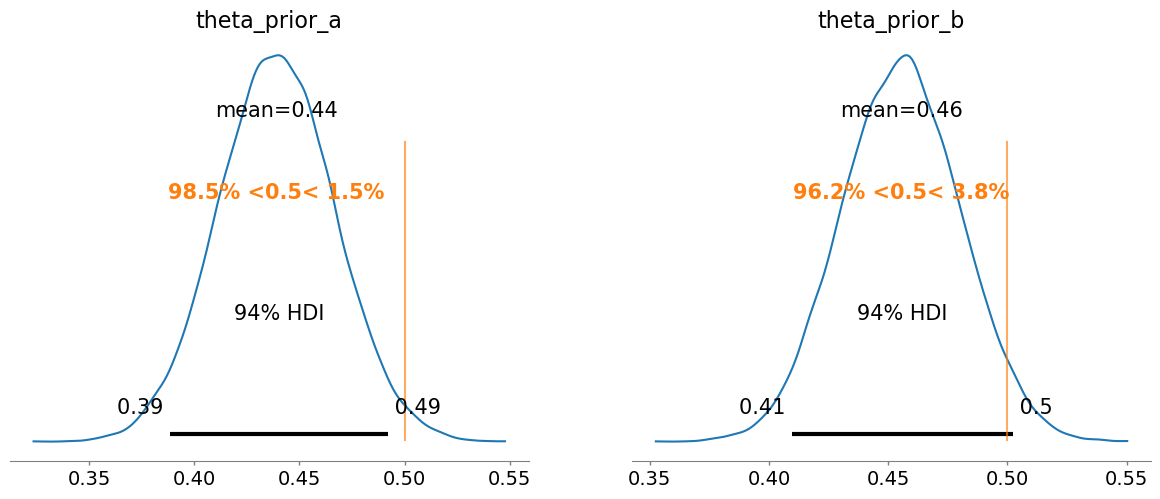

In [29]:
# Define the model
with pm.Model() as ab_model:
    # Prior distributions for conversion rates
    theta_prior_a = pm.Beta('theta_prior_a', prior_conversions_a + 1, prior_sample_size_a - prior_conversions_a + 1)
    theta_prior_b = pm.Beta('theta_prior_b', prior_conversions_b + 1, prior_sample_size_b - prior_conversions_b + 1)

    # Likelihoods for posterior data
    y_posterior_a = pm.Binomial('y_posterior_a', n=posterior_sample_size_a, p=theta_prior_a, observed=posterior_conversions_a)
    y_posterior_b = pm.Binomial('y_posterior_b', n=posterior_sample_size_b, p=theta_prior_b, observed=posterior_conversions_b)

    # Generate posterior samples
    trace = pm.sample(draws=5000, tune=2000, chains=4)

    # Print summary statistics
    print(pm.summary(trace))

    # Plot posterior distributions
    pm.plot_posterior(trace, var_names=['theta_prior_a', 'theta_prior_b'], ref_val=0.5)

    # Calculate the probability of Group B being better than Group A
    p_b_better = (trace['theta_prior_b'] > trace['theta_prior_a']).mean()
    print(f'Probability that Group B is better than Group A: {p_b_better:.2%}')

In [30]:
# subscribed

# career
# Prior dataset for Group A
prior_sample_size_b = 287
prior_conversions_b = 139

# Posterior dataset for Group A
posterior_sample_size_b = 338
posterior_conversions_b = 156

# Prior dataset for Group B
prior_sample_size_a = 345
prior_conversions_a = 153

# Posterior dataset for Group B
posterior_sample_size_a = 197
posterior_conversions_a = 93

/Users/cex/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_prior_b, theta_prior_a]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 25 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_prior_a  0.454  0.022   0.413    0.494        0.0      0.0   16990.0   
theta_prior_b  0.472  0.020   0.434    0.510        0.0      0.0   17727.0   

               ess_tail  r_hat  
theta_prior_a   13781.0    1.0  
theta_prior_b   13975.0    1.0  
Probability that Group B is better than Group A: 72.32%


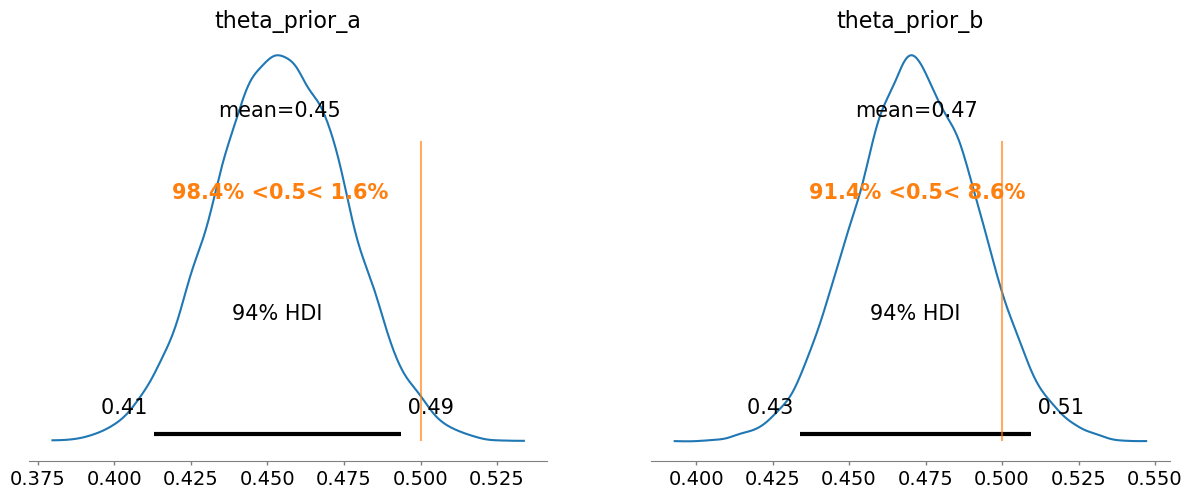

In [31]:
# Define the model
with pm.Model() as ab_model:
    # Prior distributions for conversion rates
    theta_prior_a = pm.Beta('theta_prior_a', prior_conversions_a + 1, prior_sample_size_a - prior_conversions_a + 1)
    theta_prior_b = pm.Beta('theta_prior_b', prior_conversions_b + 1, prior_sample_size_b - prior_conversions_b + 1)

    # Likelihoods for posterior data
    y_posterior_a = pm.Binomial('y_posterior_a', n=posterior_sample_size_a, p=theta_prior_a, observed=posterior_conversions_a)
    y_posterior_b = pm.Binomial('y_posterior_b', n=posterior_sample_size_b, p=theta_prior_b, observed=posterior_conversions_b)

    # Generate posterior samples
    trace = pm.sample(draws=5000, tune=2000, chains=4)

    # Print summary statistics
    print(pm.summary(trace))

    # Plot posterior distributions
    pm.plot_posterior(trace, var_names=['theta_prior_a', 'theta_prior_b'], ref_val=0.5)

    # Calculate the probability of Group B being better than Group A
    p_b_better = (trace['theta_prior_b'] > trace['theta_prior_a']).mean()
    print(f'Probability that Group B is better than Group A: {p_b_better:.2%}')

In [23]:
# downloads

# Prior dataset for Group A
prior_sample_size_b = 228
prior_conversions_b = 113

# Posterior dataset for Group A
posterior_sample_size_b = 186
posterior_conversions_b = 86

# Prior dataset for Group B
prior_sample_size_a = 303
prior_conversions_a = 132

# Posterior dataset for Group B
posterior_sample_size_a = 278
posterior_conversions_a = 129


/Users/cex/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_prior_b, theta_prior_a]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 18 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_prior_a  0.450  0.021   0.412    0.490        0.0      0.0   17502.0   
theta_prior_b  0.481  0.024   0.435    0.527        0.0      0.0   17921.0   

               ess_tail  r_hat  
theta_prior_a   14503.0    1.0  
theta_prior_b   14081.0    1.0  
Probability that Group B is better than Group A: 83.70%


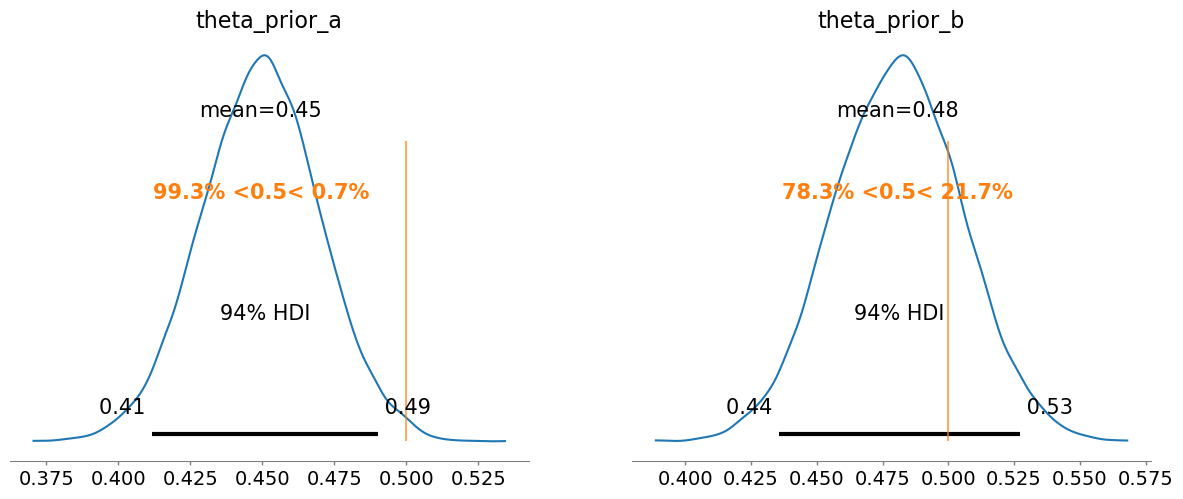

In [24]:
# Define the model
with pm.Model() as ab_model:
    # Prior distributions for conversion rates
    theta_prior_a = pm.Beta('theta_prior_a', prior_conversions_a + 1, prior_sample_size_a - prior_conversions_a + 1)
    theta_prior_b = pm.Beta('theta_prior_b', prior_conversions_b + 1, prior_sample_size_b - prior_conversions_b + 1)

    # Likelihoods for posterior data
    y_posterior_a = pm.Binomial('y_posterior_a', n=posterior_sample_size_a, p=theta_prior_a, observed=posterior_conversions_a)
    y_posterior_b = pm.Binomial('y_posterior_b', n=posterior_sample_size_b, p=theta_prior_b, observed=posterior_conversions_b)

    # Generate posterior samples
    trace = pm.sample(draws=5000, tune=2000, chains=4)

    # Print summary statistics
    print(pm.summary(trace))

    # Plot posterior distributions
    pm.plot_posterior(trace, var_names=['theta_prior_a', 'theta_prior_b'], ref_val=0.5)

    # Calculate the probability of Group B being better than Group A
    p_b_better = (trace['theta_prior_b'] > trace['theta_prior_a']).mean()
    print(f'Probability that Group B is better than Group A: {p_b_better:.2%}')

In [ ]:
# SEARCHES

# Prior dataset for Group A
prior_sample_size_a = 289
prior_conversions_a = 140

# Posterior dataset for Group A
posterior_sample_size_a = 340
posterior_conversions_a = 156

# Prior dataset for Group B
prior_sample_size_b = 354
prior_conversions_b = 155

# Posterior dataset for Group B
posterior_sample_size_b = 201
posterior_conversions_b = 95